18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step


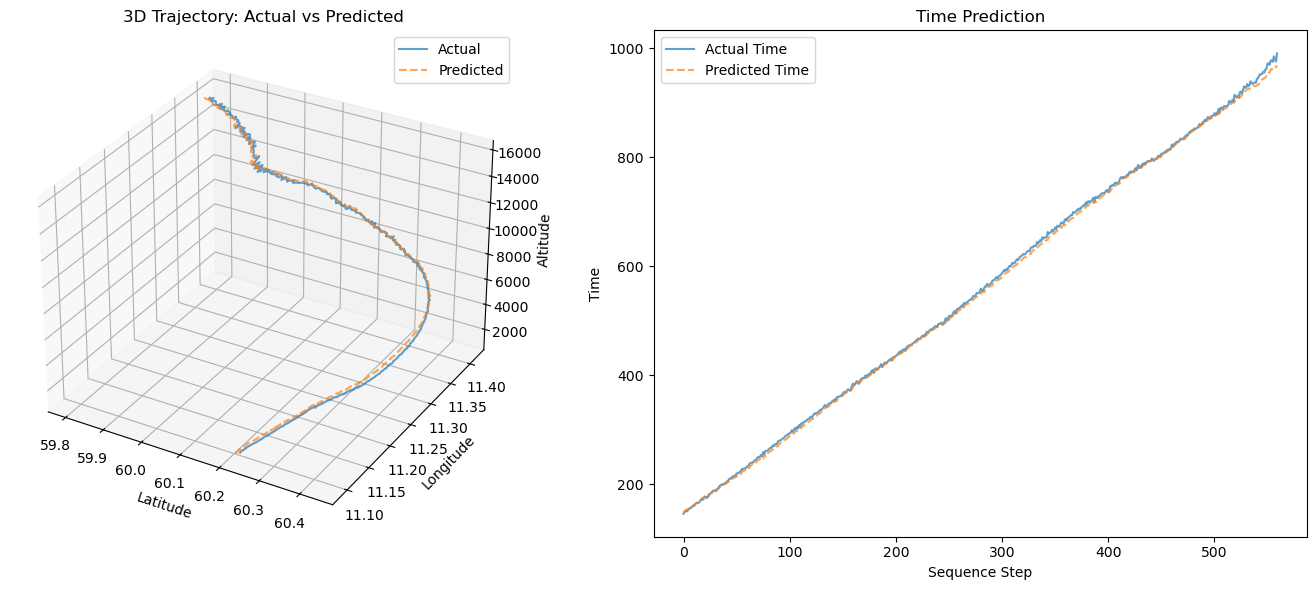

In [29]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
from mpl_toolkits.mplot3d import Axes3D

# Load model and scaler
model = load_model("coord_predictor.keras")
scaler = joblib.load("coord_scaler.pkl")

# Load data again
df = pd.read_csv(r"C:\Users\debas\AIRTRAJ\dataset-research\validated_data\Oslo6.csv")
features = ['lat', 'lon', 'alt', 'time']
data = df[features]
data_scaled = scaler.transform(data)

# Create sequences
SEQ_LENGTH = 100
def create_sequences(data, seq_length=100):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Predict
y_pred_scaled = model.predict(X)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y)

# Extract coordinates
true_lat, true_lon, true_alt, true_time = y_true.T
pred_lat, pred_lon, pred_alt, pred_time = y_pred.T

# 3D Trajectory Plot (Lat, Lon, Alt)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot(true_lat, true_lon, true_alt, label='Actual', alpha=0.7)
ax.plot(pred_lat, pred_lon, pred_alt, label='Predicted', linestyle='--', alpha=0.7)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Altitude')
ax.set_title('3D Trajectory: Actual vs Predicted')
ax.legend()

# Time Prediction Plot
ax2 = fig.add_subplot(122)
ax2.plot(true_time, label='Actual Time', alpha=0.7)
ax2.plot(pred_time, label='Predicted Time', linestyle='--', alpha=0.7)
ax2.set_title('Time Prediction')
ax2.set_xlabel('Sequence Step')
ax2.set_ylabel('Time')
ax2.legend()

plt.tight_layout()
plt.show()


In [30]:
model.save("trajectory model.keras")

In [31]:
import pandas as pd

# Load your CSV
df = pd.read_csv(r"C:\Users\debas\AIRTRAJ\dataset-research\validated_data\Oslo6.csv")

# Features to analyze
features = ['lat', 'lon', 'alt', 'time']

# Basic statistics
stats = df[features].describe()

# Extra custom stats
custom_stats = pd.DataFrame({
    'missing_values': df[features].isnull().sum(),
    'unique_values': df[features].nunique(),
    'variance': df[features].var(),
    'range': df[features].max() - df[features].min()
})

# Combine into one table
stats_combined = pd.concat([stats, custom_stats.T])
print(stats_combined)


                       lat         lon           alt          time
count           660.000000  660.000000  6.600000e+02    660.000000
mean             60.145638   11.310012  8.937193e+03    484.290943
std               0.262533    0.105435  5.852830e+03    281.452261
min              59.508120   11.097570  6.783339e+02      0.000000
25%              59.965543   11.192533  4.068830e+03    239.632657
50%              60.250047   11.373324  7.639354e+03    478.981315
75%              60.352030   11.390717  1.327862e+04    733.508310
max              60.434265   11.413091  2.233682e+04    990.259340
missing_values    0.000000    0.000000  0.000000e+00      0.000000
unique_values   659.000000  659.000000  6.600000e+02    660.000000
variance          0.068923    0.011116  3.425562e+07  79215.375230
range             0.926145    0.315521  2.165849e+04    990.259340


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step
Total actual flight path length: 128.88 km
Average horizontal error: 568.83 m
Average altitude error: 146.08 m
Average total 3D error: 591.84 m
Prediction error as % of total path length: 0.4592%


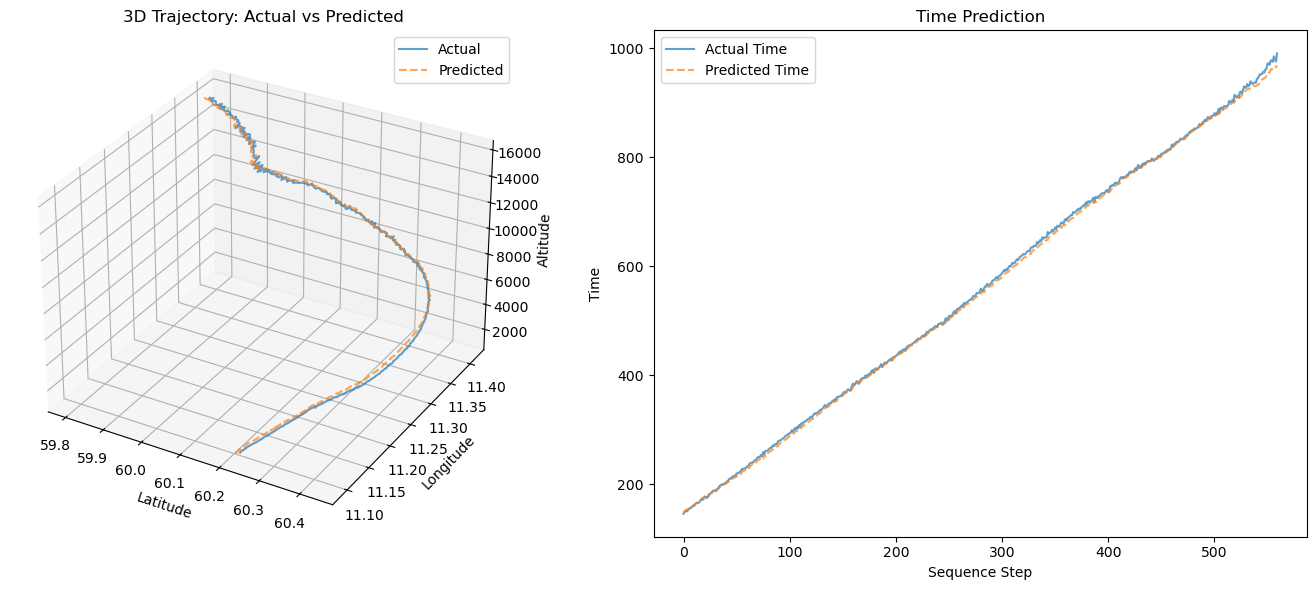

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from mpl_toolkits.mplot3d import Axes3D

# ----------------------
# Load model & scaler
# ----------------------
model = load_model("coord_predictor.keras")
scaler = joblib.load("coord_scaler.pkl")

# ----------------------
# Load data
# ----------------------
df = pd.read_csv(r"C:\Users\debas\AIRTRAJ\dataset-research\validated_data\Oslo6.csv")
features = ['lat', 'lon', 'alt', 'time']
data = df[features]
data_scaled = scaler.transform(data)

# ----------------------
# Sequence creation
# ----------------------
SEQ_LENGTH = 100
def create_sequences(data, seq_length=100):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, SEQ_LENGTH)

# ----------------------
# Prediction
# ----------------------
y_pred_scaled = model.predict(X)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y)

# Extract coordinates
true_lat, true_lon, true_alt, true_time = y_true.T
pred_lat, pred_lon, pred_alt, pred_time = y_pred.T

# ----------------------
# Accuracy calculations
# ----------------------
def haversine(lat1, lon1, lat2, lon2):
    """Great-circle distance between two points in meters."""
    R = 6371000  # Earth radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Horizontal prediction error
horizontal_error = haversine(true_lat, true_lon, pred_lat, pred_lon)

# Altitude difference (m)
alt_error = np.abs(true_alt - pred_alt)

# Total 3D prediction error
error_3d = np.sqrt(horizontal_error**2 + alt_error**2)

# ----------------------
# Flight path length (actual)
# ----------------------
segment_distances = haversine(true_lat[:-1], true_lon[:-1], true_lat[1:], true_lon[1:])
total_flight_length_m = np.sum(segment_distances)

# ----------------------
# Percentage error
# ----------------------
avg_3d_error_m = np.mean(error_3d)
percentage_error = (avg_3d_error_m / total_flight_length_m) * 100

# ----------------------
# Print results
# ----------------------
print(f"Total actual flight path length: {total_flight_length_m/1000:.2f} km")
print(f"Average horizontal error: {np.mean(horizontal_error):.2f} m")
print(f"Average altitude error: {np.mean(alt_error):.2f} m")
print(f"Average total 3D error: {avg_3d_error_m:.2f} m")
print(f"Prediction error as % of total path length: {percentage_error:.4f}%")

# ----------------------
# Plots
# ----------------------
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot(true_lat, true_lon, true_alt, label='Actual', alpha=0.7)
ax.plot(pred_lat, pred_lon, pred_alt, label='Predicted', linestyle='--', alpha=0.7)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Altitude')
ax.set_title('3D Trajectory: Actual vs Predicted')
ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(true_time, label='Actual Time', alpha=0.7)
ax2.plot(pred_time, label='Predicted Time', linestyle='--', alpha=0.7)
ax2.set_title('Time Prediction')
ax2.set_xlabel('Sequence Step')
ax2.set_ylabel('Time')
ax2.legend()

plt.tight_layout()
plt.show()
